In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D,Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Train Model with Transfer Learning

In [ ]:
from zipfile import ZipFile

with ZipFile('drive/MyDrive/dataset-baru.zip', 'r') as zipObj:
    zipObj.extractall('./')

In [ ]:
labels = os.listdir("./dataset-baru")
labels

['ClosedFace', 'OpenFace']

In [ ]:
from keras.callbacks import Callback

class CustomCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.93 and logs.get('val_loss') < 0.3):
      print("\nval_accuracy > 0.93 and val_loss < 0.3 so cancelling training!")
      self.model.stop_training = True

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    # brightness_range=[0.6, 1.0],
                                    horizontal_flip=True,
                                    validation_split= 0.2)

train_data = train_data_gen.flow_from_directory("./dataset-baru", target_size=(224,224), batch_size=32, class_mode='binary', subset='training')
validation_data = train_data_gen.flow_from_directory("./dataset-baru", target_size=(224,224), batch_size=32, class_mode='binary', subset='validation')

Found 1904 images belonging to 2 classes.
Found 476 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2

# base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = tf.keras.models.Sequential([
      base_model,
      MaxPooling2D(2, 2),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
  ])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 1280)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1474688   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
hist = model.fit(train_data, epochs=70, validation_data = validation_data, shuffle=True, validation_steps = len(validation_data), callbacks=[CustomCallback()])

Epoch 1/70
60/60 [==============================] - 56s 562ms/step - loss: 0.8103 - accuracy: 0.8724 - val_loss: 1.6783 - val_accuracy: 0.8277
Epoch 2/70
60/60 [==============================] - 31s 519ms/step - loss: 0.1467 - accuracy: 0.9491 - val_loss: 5.6306 - val_accuracy: 0.7017
Epoch 3/70
60/60 [==============================] - 31s 522ms/step - loss: 0.1411 - accuracy: 0.9527 - val_loss: 0.9271 - val_accuracy: 0.9223
Epoch 4/70
60/60 [==============================] - 31s 518ms/step - loss: 0.1164 - accuracy: 0.9601 - val_loss: 2.0978 - val_accuracy: 0.8613
Epoch 5/70
60/60 [==============================] - 31s 512ms/step - loss: 0.0855 - accuracy: 0.9669 - val_loss: 0.6374 - val_accuracy: 0.6660
Epoch 6/70
60/60 [==============================] - 31s 514ms/step - loss: 0.1067 - accuracy: 0.9606 - val_loss: 0.4887 - val_accuracy: 0.8971
Epoch 7/70
60/60 [==============================] - 31s 516ms/step - loss: 0.0692 - accuracy: 0.9758 - val_loss: 0.9202 - val_accuracy: 0.9475

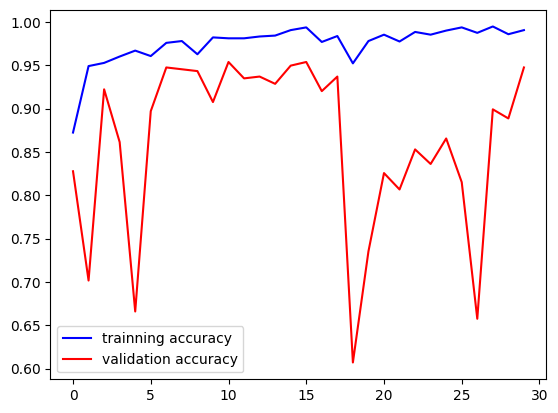

In [ ]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

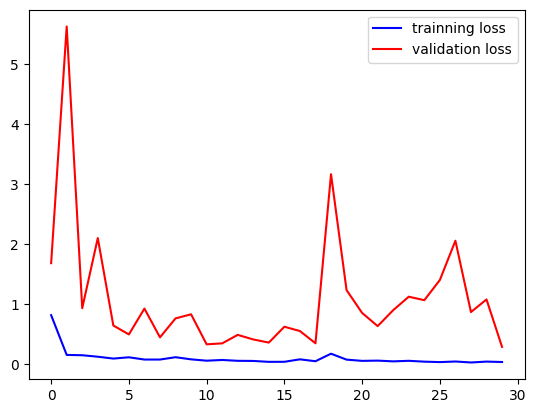

In [ ]:
plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
model.save("full-face-drowsiness2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Convert model to tensorflow lite

In [ ]:
import tensorflow as tf

# Load the trained TensorFlow model
model = tf.keras.models.load_model('./full-face-drowsiness2.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('full-face-drowsiness2.tflite', 'wb') as f:
    f.write(tflite_model)
